In [1]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pickle
import pandas as pd
from sklearn.model_selection import KFold

import lime
from lime import lime_tabular

import warnings
warnings.filterwarnings('ignore')
import json
import pickle
import seaborn as sn
import preprocess

In [2]:
data_type = 'caco'
feature_type = 'klek'

## Load data

In [3]:
exp_rf = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_rf.csv')
exp_hist = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_hist.csv')
exp_lgbm = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_lgbm.csv')
exp_xgboost = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_xgboost.csv')
exp_svr = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_svr.csv')

In [4]:
data_path = '../../data/processed/{}_{}_all.csv'.format(data_type, feature_type)
df = pd.read_csv(data_path)
X = df.loc[:, df.columns != df.columns[0]]
idxs = preprocess.remove_low_variance(X, threshold=0.01)

In [5]:
with open('../../klek_keys_dict.pickle', 'rb') as fp:
    Klek_keys_dict = pickle.load(fp)

In [6]:
def map_to_smarts(df):
    df_mapped = df + 1
    df_mapped = df_mapped.applymap(lambda x: Klek_keys_dict[x])
    return df_mapped

## Lime - aggregation by score 

In [7]:
def get_scores(explanations, len_data):
    scores = np.zeros(4860)
    for index, exp in explanations.iterrows():
        num, score = int(exp['0']), exp['1']
        scores[num] += abs(score)
    scores /= len_data
    return scores

In [8]:
def get_top_k(explanations, k, len_data):
    scores = get_scores(explanations, len_data)
    top_f = np.argsort(abs(scores))[::-1]
    return top_f[:k]

In [9]:
k = 10
#df_top_5 = get_top_k(exp_rf, k, len(X))
len_data = 1000
top_10 = pd.DataFrame({'Random_forest': list(get_top_k(exp_rf, k, len_data)), 'Hist': list(get_top_k(exp_hist, k, len_data)), 'Lgbm': list(get_top_k(exp_lgbm, k, len_data)), 'Xgboost': list(get_top_k(exp_xgboost, k, len_data)), 'SVR': list(get_top_k(exp_svr, k, len_data))})
top_10

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,811,3800,811,3180,1146
1,3864,811,2137,1148,224
2,3609,3082,3082,3013,476
3,3181,4665,4283,3956,3609
4,138,3609,4665,4538,2949
5,3139,1427,3949,3591,1148
6,224,224,3784,3892,3161
7,3082,706,138,3933,1645
8,2030,4538,3887,4843,1013
9,4581,1148,3139,3779,16


In [10]:
top_10_smarts = map_to_smarts(top_10)
top_10_smarts.to_csv(f'files/{data_type}/{data_type}_{feature_type}_agg_by_score.csv', index=False)
top_10_smarts

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,[!#1][NH][NH][CH]=O,CCOC(=O)CNC=O,[!#1][NH][NH][CH]=O,c1cnn(c1)c2ccccc2,[!#1][O-]
1,Clc1cccc(c1)N2C(=O)CCC2=O,[!#1][NH][NH][CH]=O,[!#1]c1n[cH]nc2[nH][cH]nc12,[!#1][SH],[!#1][CH]1[CH2][CH2][CH2]O1
2,Cc1ccco1,c1cc2ccccc2n1c3ccccc3,c1cc2ccccc2n1c3ccccc3,C=NC=NNC=O,[!#1][CH2][NH]C([CH3])([CH3])[CH3]
3,c1cnoc1,OC(=O)CCCC(=O)O,NCC(O)CO,COC,Cc1ccco1
4,[!#1][CH]=C([NH]C(=O)[!#1])C(=O)[!#1],Cc1ccco1,OC(=O)CCCC(=O)O,O=CN1CCCCC1,Br
5,c1ccc2n[nH]nc2c1,[!#1]C(=O)c1[cH][cH][cH][cH]c1[CH3],CNN=C,Cc1cccc2ccccc12,[!#1][SH]
6,[!#1][CH]1[CH2][CH2][CH2]O1,[!#1][CH]1[CH2][CH2][CH2]O1,CCNCC=O,CN(C)CC(=O)N,C1CN(C(N1c2ccccc2)c3ccccc3)c4ccccc4
7,c1cc2ccccc2n1c3ccccc3,[!#1][NH][CH]([CH3])C(=O)[!#1],[!#1][CH]=C([NH]C(=O)[!#1])C(=O)[!#1],CNC(=O)O,[!#1]c1[cH][cH]c([!#1])c([!#1])c1[!#1]
8,[!#1]c1[cH]nn([cH]1)c2[cH][cH][cH][cH][cH]2,O=CN1CCCCC1,CN(C)C=N,S=C(Nc1ccccc1)Nc2ccccc2,[!#1][NH]c1[cH][cH]c([!#1])[cH]c1[CH3]
9,O=COc1ccc2ccccc2c1,[!#1][SH],c1ccc2n[nH]nc2c1,CCNC(=S)NC(CC=O)c1ccccc1,[!#1][CH]([!#1])[OH]


## Lime - aggregation by top k

In [11]:
def get_scores_top_k(explanations, k, len_data):
    scores = np.zeros(4860)
    top_ks = [explanations[x:x+k] for x in range(0, len(explanations), len(idxs))]
    assert len(top_ks)==len_data
    for i in range(0,4860):
        score = 0
        for top in top_ks:
            if i in list(top['0']): score +=1
        scores[i] = score
    scores /= len_data
    return scores

In [12]:
def get_top_k_top_k(explanations, k, len_data):
    scores = get_scores_top_k(explanations, k, len_data)
    top_f = np.argsort(scores)[::-1]
    return top_f[:k]

In [13]:
k = 10
topk_10 = pd.DataFrame({'Random_forest': list(get_top_k_top_k(exp_rf, k, len_data)), 'Hist': list(get_top_k_top_k(exp_hist, k, len_data)), 'Lgbm': list(get_top_k_top_k(exp_lgbm, k, len_data)), 'Xgboost': list(get_top_k_top_k(exp_xgboost, k, len_data)), 'SVR': list(get_top_k_top_k(exp_svr, k, len_data))})
topk_10

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,3864,3082,4283,3956,1645
1,811,3609,4665,1148,476
2,3609,811,2137,3180,3609
3,3181,3800,3949,3013,3161
4,3139,4665,811,4538,224
5,138,224,3082,3591,2949
6,224,1427,3784,3892,1146
7,3082,706,138,3933,1148
8,2030,1148,3139,4843,1013
9,4581,4538,3887,3779,16


In [14]:
topk_10_smarts = map_to_smarts(topk_10)
topk_10_smarts.to_csv(f'files/{data_type}/{data_type}_{feature_type}_agg_by_topk.csv', index=False)
topk_10_smarts

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,Clc1cccc(c1)N2C(=O)CCC2=O,c1cc2ccccc2n1c3ccccc3,NCC(O)CO,COC,[!#1]c1[cH][cH]c([!#1])c([!#1])c1[!#1]
1,[!#1][NH][NH][CH]=O,Cc1ccco1,OC(=O)CCCC(=O)O,[!#1][SH],[!#1][CH2][NH]C([CH3])([CH3])[CH3]
2,Cc1ccco1,[!#1][NH][NH][CH]=O,[!#1]c1n[cH]nc2[nH][cH]nc12,c1cnn(c1)c2ccccc2,Cc1ccco1
3,c1cnoc1,CCOC(=O)CNC=O,CNN=C,C=NC=NNC=O,C1CN(C(N1c2ccccc2)c3ccccc3)c4ccccc4
4,c1ccc2n[nH]nc2c1,OC(=O)CCCC(=O)O,[!#1][NH][NH][CH]=O,O=CN1CCCCC1,[!#1][CH]1[CH2][CH2][CH2]O1
5,[!#1][CH]=C([NH]C(=O)[!#1])C(=O)[!#1],[!#1][CH]1[CH2][CH2][CH2]O1,c1cc2ccccc2n1c3ccccc3,Cc1cccc2ccccc12,Br
6,[!#1][CH]1[CH2][CH2][CH2]O1,[!#1]C(=O)c1[cH][cH][cH][cH]c1[CH3],CCNCC=O,CN(C)CC(=O)N,[!#1][O-]
7,c1cc2ccccc2n1c3ccccc3,[!#1][NH][CH]([CH3])C(=O)[!#1],[!#1][CH]=C([NH]C(=O)[!#1])C(=O)[!#1],CNC(=O)O,[!#1][SH]
8,[!#1]c1[cH]nn([cH]1)c2[cH][cH][cH][cH][cH]2,[!#1][SH],c1ccc2n[nH]nc2c1,S=C(Nc1ccccc1)Nc2ccccc2,[!#1][NH]c1[cH][cH]c([!#1])[cH]c1[CH3]
9,O=COc1ccc2ccccc2c1,O=CN1CCCCC1,CN(C)C=N,CCNC(=S)NC(CC=O)c1ccccc1,[!#1][CH]([!#1])[OH]


## Lime - comparison of models

In [15]:
def get_scores_top_k_example(explanations, k, len_data):
    top_ks = [explanations[x:x+k] for x in range(0, len(explanations), len(idxs))]
    assert len(top_ks)==len_data
    return top_ks

In [16]:
def get_top_k_2models_score(explanations_1, explanations_2, k, len_data):
    top_ks_1 = get_scores_top_k_example(explanations_1, k, len_data)
    top_ks_2 = get_scores_top_k_example(explanations_2, k, len_data)
    scores = []
    for j in range(0,4860):
        for i in range(len(top_ks_1)):
            score = len(set(top_ks_1[i]['0']).intersection(top_ks_2[i]['0']))
            score /= k
            scores.append(score)
    return np.mean(scores)

In [17]:
get_top_k_2models_score(exp_rf, exp_hist, 10, len_data)

0.4588000000000006

In [18]:
'''
models_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]
scores = []
for i, exp in enumerate(models_list):
    for exp2 in models_list[i+1:]:
        scores.append(get_top_k_2models_score(exp, exp2, 10, len_data))
print(scores)
'''

'\nmodels_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]\nscores = []\nfor i, exp in enumerate(models_list):\n    for exp2 in models_list[i+1:]:\n        scores.append(get_top_k_2models_score(exp, exp2, 10, len_data))\nprint(scores)\n'

In [19]:
models_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]
scores = []
for i, exp in enumerate(models_list):
    for exp2 in models_list:
        scores.append(get_top_k_2models_score(exp, exp2, 10, len_data))
print(scores)

[1.0, 0.4588000000000006, 0.34760000000000046, 0.0, 0.22050000000000006, 0.4588000000000006, 1.0, 0.3339000000000008, 0.12770000000000004, 0.2933000000000001, 0.34760000000000046, 0.3339000000000008, 1.0, 0.0014999999999999992, 0.03140000000000002, 0.0, 0.12770000000000004, 0.0014999999999999992, 1.0, 0.10000000000000098, 0.22050000000000006, 0.2933000000000001, 0.03140000000000002, 0.10000000000000098, 1.0]


<AxesSubplot: >

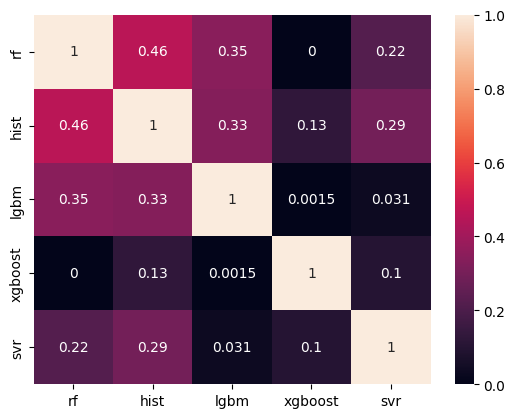

In [20]:
scores_arr = np.array(scores).reshape(5,5)
labels = ['rf', 'hist', 'lgbm', 'xgboost', 'svr']
heatmap_models = sn.heatmap(scores_arr, xticklabels=labels, yticklabels=labels, annot=True)
heatmap_models

In [21]:
fig = heatmap_models.get_figure()
fig.savefig(f"files/{data_type}/{data_type}_{feature_type}_models_heatmap.png") 

## Lime - comparison of models (features)

In [22]:
def get_top_k_2models(explanations_1, explanations_2, k, len_data):
    top_ks_1 = get_scores_top_k_example(explanations_1, k, len_data)
    top_ks_2 = get_scores_top_k_example(explanations_2, k, len_data)
    scores = np.zeros(4860)
    for j in range(0,4860):
        for i in range(len(top_ks_1)):
            common_fs = list(set(top_ks_1[i]['0']).intersection(top_ks_2[i]['0']))
            scores[common_fs] += 1
    scores /= len_data  
    top_f = np.argsort(scores)[::-1]
    return top_f[:k]

In [23]:
def get_top_k_more_models(explanations, k, len_data):
    top_ks = [get_scores_top_k_example(exp, k, len_data) for exp in explanations]
    scores = np.zeros(4860)
    for j in range(0,4860):
        for i in range(len(top_ks[0])):
            common_fs = list(set(top_ks[0][i]['0']).intersection(*[top[i]['0'] for top in top_ks]))
            scores[common_fs] += 1
    scores /= len_data  
    top_f = np.argsort(scores)[::-1]
    return top_f[:k]

In [24]:
#get_top_k_2models(exp_rf, exp_hist, 10, len_data)

In [25]:
models_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]
labels = ['rf', 'hist', 'lgbm', 'xgboost', 'svr']
comp_models = pd.DataFrame()
for i, exp in enumerate(models_list):
    for j, exp2 in enumerate(models_list[i+1:]):
        column_name = labels[i] + '/' + labels[j+i+1]
        comp_models[column_name] = get_top_k_2models(exp, exp2, 10, len_data)
comp_models['all'] = get_top_k_more_models(models_list, 10, len_data)
comp_models

,rf/hist,rf/lgbm,rf/xgboost,rf/svr,hist/lgbm,hist/xgboost,hist/svr,lgbm/xgboost,lgbm/svr,xgboost/svr,all
0,3609,811,4859,3609,4665,1148,3609,3949,811,1148,4859
1,811,138,1613,224,3082,4538,224,1612,3139,4859,1613
2,224,3139,1615,811,811,4859,1148,1614,2137,1615,1615
3,3082,3082,1616,3139,3139,1612,3161,1615,3161,1616,1616
4,3800,224,1617,3161,3784,1614,811,1616,224,1617,1617
5,3139,3161,1618,4859,3161,1615,3139,1617,4859,1618,1618
6,2030,4859,1619,1621,224,1616,1621,1618,1617,1619,1619
7,3864,1618,1620,1617,2137,1617,1617,1619,1618,1620,1620
8,3161,1619,1621,1618,138,1618,1618,1620,1619,1621,1621
9,208,1620,1622,1619,1617,1619,1619,1621,1620,1622,1622


In [26]:
comp_models_smarts = map_to_smarts(comp_models)
comp_models_smarts.to_csv(f'files/{data_type}/{data_type}_{feature_type}_models_comparison.csv', index=False)
comp_models_smarts

,rf/hist,rf/lgbm,rf/xgboost,rf/svr,hist/lgbm,hist/xgboost,hist/svr,lgbm/xgboost,lgbm/svr,xgboost/svr,all
0,Cc1ccco1,[!#1][NH][NH][CH]=O,SCCS(=O)=O,Cc1ccco1,OC(=O)CCCC(=O)O,[!#1][SH],Cc1ccco1,CNN=C,[!#1][NH][NH][CH]=O,[!#1][SH],SCCS(=O)=O
1,[!#1][NH][NH][CH]=O,[!#1][CH]=C([NH]C(=O)[!#1])C(=O)[!#1],[!#1]c1[cH][cH][cH]c([OH])[cH]1,[!#1][CH]1[CH2][CH2][CH2]O1,c1cc2ccccc2n1c3ccccc3,O=CN1CCCCC1,[!#1][CH]1[CH2][CH2][CH2]O1,[!#1]c1[cH][cH][cH]c([NH2])[cH]1,c1ccc2n[nH]nc2c1,SCCS(=O)=O,[!#1]c1[cH][cH][cH]c([OH])[cH]1
2,[!#1][CH]1[CH2][CH2][CH2]O1,c1ccc2n[nH]nc2c1,[!#1]c1[cH][cH][cH]c(Cl)[cH]1,[!#1][NH][NH][CH]=O,[!#1][NH][NH][CH]=O,SCCS(=O)=O,[!#1][SH],[!#1]c1[cH][cH][cH]c(Br)[cH]1,[!#1]c1n[cH]nc2[nH][cH]nc12,[!#1]c1[cH][cH][cH]c(Cl)[cH]1,[!#1]c1[cH][cH][cH]c(Cl)[cH]1
3,c1cc2ccccc2n1c3ccccc3,c1cc2ccccc2n1c3ccccc3,[!#1]c1[cH][cH][cH]c(Cl)c1[CH3],c1ccc2n[nH]nc2c1,c1ccc2n[nH]nc2c1,[!#1]c1[cH][cH][cH]c([NH2])[cH]1,C1CN(C(N1c2ccccc2)c3ccccc3)c4ccccc4,[!#1]c1[cH][cH][cH]c(Cl)[cH]1,C1CN(C(N1c2ccccc2)c3ccccc3)c4ccccc4,[!#1]c1[cH][cH][cH]c(Cl)c1[CH3],[!#1]c1[cH][cH][cH]c(Cl)c1[CH3]
4,CCOC(=O)CNC=O,[!#1][CH]1[CH2][CH2][CH2]O1,[!#1]c1[cH][cH][cH]c(Cl)c1Cl,C1CN(C(N1c2ccccc2)c3ccccc3)c4ccccc4,CCNCC=O,[!#1]c1[cH][cH][cH]c(Br)[cH]1,[!#1][NH][NH][CH]=O,[!#1]c1[cH][cH][cH]c(Cl)c1[CH3],[!#1][CH]1[CH2][CH2][CH2]O1,[!#1]c1[cH][cH][cH]c(Cl)c1Cl,[!#1]c1[cH][cH][cH]c(Cl)c1Cl
5,c1ccc2n[nH]nc2c1,C1CN(C(N1c2ccccc2)c3ccccc3)c4ccccc4,[!#1]c1[cH][cH][cH]c(F)[cH]1,SCCS(=O)=O,C1CN(C(N1c2ccccc2)c3ccccc3)c4ccccc4,[!#1]c1[cH][cH][cH]c(Cl)[cH]1,c1ccc2n[nH]nc2c1,[!#1]c1[cH][cH][cH]c(Cl)c1Cl,SCCS(=O)=O,[!#1]c1[cH][cH][cH]c(F)[cH]1,[!#1]c1[cH][cH][cH]c(F)[cH]1
6,[!#1]c1[cH]nn([cH]1)c2[cH][cH][cH][cH][cH]2,SCCS(=O)=O,[!#1]c1[cH][cH][cH]c(I)[cH]1,[!#1]c1[cH][cH][cH]c2[cH][cH][cH][cH]c12,[!#1][CH]1[CH2][CH2][CH2]O1,[!#1]c1[cH][cH][cH]c(Cl)c1[CH3],[!#1]c1[cH][cH][cH]c2[cH][cH][cH][cH]c12,[!#1]c1[cH][cH][cH]c(F)[cH]1,[!#1]c1[cH][cH][cH]c(Cl)c1Cl,[!#1]c1[cH][cH][cH]c(I)[cH]1,[!#1]c1[cH][cH][cH]c(I)[cH]1
7,Clc1cccc(c1)N2C(=O)CCC2=O,[!#1]c1[cH][cH][cH]c(F)[cH]1,[!#1]c1[cH][cH][cH]c(O[CH3])[cH]1,[!#1]c1[cH][cH][cH]c(Cl)c1Cl,[!#1]c1n[cH]nc2[nH][cH]nc12,[!#1]c1[cH][cH][cH]c(Cl)c1Cl,[!#1]c1[cH][cH][cH]c(Cl)c1Cl,[!#1]c1[cH][cH][cH]c(I)[cH]1,[!#1]c1[cH][cH][cH]c(F)[cH]1,[!#1]c1[cH][cH][cH]c(O[CH3])[cH]1,[!#1]c1[cH][cH][cH]c(O[CH3])[cH]1
8,C1CN(C(N1c2ccccc2)c3ccccc3)c4ccccc4,[!#1]c1[cH][cH][cH]c(I)[cH]1,[!#1]c1[cH][cH][cH]c2[cH][cH][cH][cH]c12,[!#1]c1[cH][cH][cH]c(F)[cH]1,[!#1][CH]=C([NH]C(=O)[!#1])C(=O)[!#1],[!#1]c1[cH][cH][cH]c(F)[cH]1,[!#1]c1[cH][cH][cH]c(F)[cH]1,[!#1]c1[cH][cH][cH]c(O[CH3])[cH]1,[!#1]c1[cH][cH][cH]c(I)[cH]1,[!#1]c1[cH][cH][cH]c2[cH][cH][cH][cH]c12,[!#1]c1[cH][cH][cH]c2[cH][cH][cH][cH]c12
9,[!#1][CH]1[CH2][CH2][CH]([CH2][CH2]1)C([CH3])(...,[!#1]c1[cH][cH][cH]c(O[CH3])[cH]1,[!#1]c1[cH][cH][cH]c2[cH][cH][cH]c([!#1])c12,[!#1]c1[cH][cH][cH]c(I)[cH]1,[!#1]c1[cH][cH][cH]c(Cl)c1Cl,[!#1]c1[cH][cH][cH]c(I)[cH]1,[!#1]c1[cH][cH][cH]c(I)[cH]1,[!#1]c1[cH][cH][cH]c2[cH][cH][cH][cH]c12,[!#1]c1[cH][cH][cH]c(O[CH3])[cH]1,[!#1]c1[cH][cH][cH]c2[cH][cH][cH]c([!#1])c12,[!#1]c1[cH][cH][cH]c2[cH][cH][cH]c([!#1])c12
